# Example of catalogue creation using STRAWBERRY

This notebook presents how one can use STRAWBERRY to analyse individual and stacks of dark matter haloes. This example is designed to work with simulations run using <a href="https://wwwmpa.mpa-garching.mpg.de/gadget4/">Gadget-4</a>. To run this example, a low resolution snapshot and a SubFind catalogue are provided in the `example_data` directory. Note that we also provide the Config and parameter files that were used to generate these data. 

Disclaimer: due to file size limitation, the snapshot has been manually split into 4 files. While in this context they can be used just as if they were generated directly in this state, we inform the user that the headers show some discrepancies in attributes not used by the code. 
Furthermore, this notebook uses multiprocessing to analyse several haloes simultaneously. To achieve this, we load the snapshot as shared memory NumPy arrays. From experience, these arrays can sometimes cause issues when the code does not exit properly, most notably staying loaded in memory after the Python kernel has unexpectedly died. While precautions have been taken to make sure the memory is freed upon exit, we cannot guaranty this will happen 100% of the time, and as such we advise caution when using the methodology presented below. Your RAM, your responsibility. IMPORTANT: This code has fewer safeguards than the example_catalogue **make sure to run the last cell before exiting the notebook**!

The example simulation snapshot we have provided uses the cosmological parameters of the Illustris TNG300 simulation, namely, $\Omega_{\rm m,0} = 0.3089$, $\Omega_{\Lambda,0} = 0.6911$, $\Omega_{\rm b,0} = 0.045$, $n_{\rm s} = 0.9667$, and $h = 0.6774$. It represents a comoving periodic box of side length $L_{\rm box} = 205 h^{-1}{\rm Mpc}$ sampled by $N=156^3$ particles, at redshift $z=0$. The initial condition were generated at $z=99$ using the built-in NGenIC initial condition generator and using the Eisenstein & Hu (1996) approximation to the linear matter power spectrum.

Data needed to run STRAWBERRY:

Particles
<ul>
    <li> IDs
    <li> Positions
    <li> Velocities
    <li> Accelerations
    <li> Gravitational Potential
</ul>

FoF Groups
<ul>
    <li> Group positions
    <li> Access to group particles (Gadget-4 does this with offsets and lengths)
</ul>

The neighbours will be generated by the code below but can also be provided separately. Note that STRAWBERRY expects 64-bit floats and integers as inputs, so don't forget to convert simulation outputs to double precision.

Additional dependencies:
to run this notebook, you'll need to install two additional python packages: `tqdm` and `h5py`. These are both available through PyPI.

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import signal
import atexit
import sys
from multiprocessing import shared_memory, Queue, Process
import h5py
from strawberry_cython import ParticleAssigner as PA
from strawberry_cython import Halo
from scipy.spatial import cKDTree
import time
import os

from tqdm import tqdm

from scipy.stats import binned_statistic
from scipy.integrate import cumulative_trapezoid

from scipy.interpolate import griddata
from scipy import linalg

# Setup and reading header and FoF groups

In [4]:
 # Number of particles per dimension
Npart = 156

# Snapshot number
snapshot = 49 

# The vaule of of the large scale delta tilde parameter. 
# Other 'physical' values can be computed using the ParticleAssigner method get_delta_th
# Tip: You can declare a ParticleAssigner with small arrays and the correct cosmological parameters to use this method.
d_th = 4.55165 

# The number of neighbours to be assigned to each particle
N_ngb = 10

# The comoving boxsize
Lbox = 205.0

# The number of processes to be used at run time.
n_proc = 4

# Comoving radial bins used for profiles
r_bins = np.geomspace(1e-2,4,50)

# Suffix used for catalogue fies
threshold = f'custom-d{d_th:.3}'

start_full = time.time()

# Reading simulation (More precisely prior halo catalogue to analyse)
print("reading sim...", flush = True)

# Simulation file paths
basedir, t = f"./example_data/", snapshot
snapout = basedir + f"outputs/snapdir_{t:03}/snapshot_{t:03}.hdf5"
fofout = basedir + f"outputs/fof_subhalo_tab_{t:03}.hdf5"

# Output path
output_dir = basedir + 'strawberry_haloes/'

if not os.path.isdir(output_dir):
    os.makedirs(output_dir) 

# Sentinel format: (status, payload)
# status: "OK" or "ERR"
# payload: result or error message
# These are used to track the status of the multiple processes we'll be launching
SENTINEL = ("DONE", None)

# Read FoF catalogue and snapshot header
fof = {}
header = {}

# Note to self: make it adapt to multiple fof files
with h5py.File(fofout, 'r') as f:
    fof["halo_len"] = f["Group/GroupLen"][:]
    fof["halo_mfof"] = f["Group/GroupMass"][:]
    fof["halo_pos"] = f["Group/GroupPos"][:]
    fof["halo_vel"] = f["Group/GroupVel"][:]
    group_len = np.uint64(f['Group/GroupLenType'][:]).T[1]
    group_offsets = np.uint64(f['Group/GroupOffsetType'][:]).T[1]  

if os.path.isfile(snapout):
    with h5py.File(snapout, "r") as f:
        header["NpartTotal"] = f["Header"].attrs["NumPart_Total"][1]
        header["Redshift"] = f["Header"].attrs["Redshift"]
        header["Time"] = f["Header"].attrs["Time"]
        header["ParticleMass"] = f["Header"].attrs['MassTable'][1]*1e10
        
        header['HubbleParam'] = f["Parameters"].attrs["HubbleParam"]
        header["Omega"] = f["Parameters"].attrs["Omega0"]
        header['OmegaLambda'] = f["Parameters"].attrs["OmegaLambda"]
        header["OmegaBaryon"] = f["Parameters"].attrs["OmegaBaryon"]
        header["ns"] = f["Parameters"].attrs["PrimordialIndex"]
        header['Sigma8'] = f["Parameters"].attrs["Sigma8"]
        header["BoxSize"] = f["Parameters"].attrs["BoxSize"]
        header["Softening"] = f["Parameters"].attrs["SofteningComovingClass0"]

elif os.path.isfile(snapout[:-17] + f"snapshot_{t:03}.0.hdf5"):
    FILEPATH = snapout[:-17] + f"snapshot_{t:03}.0.hdf5"
    with h5py.File(FILEPATH, "r") as f: 
        header["NpartTotal"] = f["Header"].attrs["NumPart_Total"][1]
        header["Redshift"] = f["Header"].attrs["Redshift"]
        header["Time"] = f["Header"].attrs["Time"]
        header["ParticleMass"] = f["Header"].attrs['MassTable'][1]*1e10
        
        header['HubbleParam'] = f["Parameters"].attrs["HubbleParam"]
        header["Omega"] = f["Parameters"].attrs["Omega0"]
        header['OmegaLambda'] = f["Parameters"].attrs["OmegaLambda"]
        header["OmegaBaryon"] = f["Parameters"].attrs["OmegaBaryon"]
        header["ns"] = f["Parameters"].attrs["PrimordialIndex"]
        header['Sigma8'] = f["Parameters"].attrs["Sigma8"]
        header["BoxSize"] = f["Parameters"].attrs["BoxSize"]
        header["Softening"] = f["Parameters"].attrs["SofteningComovingClass0"]
else:
    raise ValueError("Couldn't find snapshots\n" + snapout+"\n Or\n"+ snapout[:-17] + f"snapdir_{t:03}/snapshot_{t:03}.0.hdf5")

reading sim...


# Loading simulation data as shared memory object for multiprocessing
/!\ For safety purposes, manually clean up this shared memory by calling `cleanup()` before kill/restarting this notebook.
If this shared memory is not cleared up properly, it will continue to occupy space on your RAM. 
On Linux systems, you can check your shared memory using: `ls -lh /dev/shm`. If you see anomalous files named `psm_XXXXXXXX` after killing the kernel, it is likely that the shared memory wasn't cleared properly. You should proceed to delete these as they are taking up your RAM and can't easily be accessed again.

In [5]:
# Define cleanup function to clean shared memory objects

shm_objects = []
def cleanup(signum=None, frame=None):
    """Cleanup shared memory and exit."""
    print(f"\n[cleanup] Caught signal {signum}, cleaning up shared memory...")
    for shm in shm_objects:
        try:
            shm.close()
            shm.unlink()
            print(f"[cleanup] Freed {shm.name}")
        except FileNotFoundError:
            pass
        except Exception as e:
            print(f"[cleanup] Error cleaning {shm.name}: {e}")
    sys.exit(1)

# register handlers early
signal.signal(signal.SIGINT, cleanup)   # Ctrl-C
signal.signal(signal.SIGTERM, cleanup)  # SLURM kill
atexit.register(cleanup)


# Reading snapshot, and created shared memory for sub-processes

shape = (header["NpartTotal"],)
dtype = np.float64
size = int(np.prod(shape) * np.dtype(dtype).itemsize)

dtype_ids = np.int64
size_ids = int(np.prod(shape) * np.dtype(dtype_ids).itemsize)

shape_3 = (header["NpartTotal"],3)
dtype_3 = np.float64
size_3 = int(np.prod(shape_3) * np.dtype(dtype_3).itemsize)

shape_ngb = (header["NpartTotal"],N_ngb)
dtype_ngb = np.int64
size_ngb = int(np.prod(shape_ngb) * np.dtype(dtype_ngb).itemsize)

shm_pot = shared_memory.SharedMemory(create=True, size=size)
pot = np.ndarray(shape, dtype=dtype, buffer=shm_pot.buf)

shm_pos = shared_memory.SharedMemory(create=True, size=size_3)
pos = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_pos.buf)

shm_vel = shared_memory.SharedMemory(create=True, size=size_3)
vel = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_vel.buf)

shm_acc = shared_memory.SharedMemory(create=True, size=size_3)
acc = np.ndarray(shape_3, dtype=dtype_3, buffer=shm_acc.buf)

shm_ngbs = shared_memory.SharedMemory(create=True, size=size_ngb)
ngbs = np.ndarray(shape_ngb, dtype=dtype_ngb, buffer=shm_ngbs.buf)

shm_ids = shared_memory.SharedMemory(create=True, size=size_ids)
ids_all = np.ndarray(shape, dtype=dtype_ids, buffer=shm_ids.buf)

shm_names = [shm_pot.name, shm_pos.name, shm_vel.name, shm_acc.name, shm_ngbs.name, shm_ids.name]
shm_shapes = [shape, shape_3, shape_3, shape_3, shape_ngb, shape]
shm_dtypes = [dtype, dtype_3, dtype_3, dtype_3, dtype_ngb, dtype_ids]
shm_objects = [shm_pot, shm_pos, shm_vel, shm_acc, shm_ngbs, shm_ids]



if os.path.isfile(snapout):
    with h5py.File(snapout, "r") as f:
        ids_all[:] = f["PartType1"]["ParticleIDs"][:] - 1
        pos[:] = f["PartType1"]["Coordinates"][:]
        vel[:] = f["PartType1"]["Velocities"][:] * np.sqrt(header["Time"]) # peculiar velocity a*dx/dt 
        pot[:] = f["PartType1"]["Potential"][:]
        acc[:] = f["PartType1"]["Acceleration"][:] * header["Time"] # Comoving acceleration

elif os.path.isfile(snapout[:-17] + f"snapshot_{t:03}.0.hdf5"):
    print(snapout + " not found, trying multifile mode...")
    nfiles = 0
    SNAPDIR = snapout[:-17]
    for root, dirs, files in sorted(os.walk(SNAPDIR)):
        nfiles += len([file for file in files if ('snapshot' in file)])
        nfiles -= len([file for file in files if ('bak-' in file)]) # temporary fix in case there are backup snapshots in the directory
        
    if nfiles > 0:
        print(f"Found {nfiles} files. Reading...")
        i_filled = 0
        for k in range(nfiles):
            print(k)
            FILEPATH = snapout[:-17] + f"snapshot_{t:03}.{k}.hdf5"
            with h5py.File(FILEPATH, "r") as f:
                part_ids = f["PartType1"]["ParticleIDs"][:] - 1
                ids_all[i_filled:i_filled+part_ids.size] = part_ids
                pos[part_ids] = f["PartType1"]["Coordinates"][:]
                vel[part_ids] = f["PartType1"]["Velocities"][:] * np.sqrt(header["Time"]) # peculiar velocity a*dx/dt 
                pot[part_ids] = f["PartType1"]["Potential"][:]
                acc[part_ids] = f["PartType1"]["Acceleration"][:] * header["Time"] # Comoving acceleration
                i_filled += part_ids.size
        print("Done.")
    else:
        raise OSError(f"No matching files found in {SNAPDIR}")
else:
    raise ValueError("Couldn't find snapshots\n" + snapout+"\n Or\n"+ snapout[:-17] + f"snapshot_{t:03}.0.hdf5")


./example_data/outputs/snapdir_049/snapshot_049.hdf5 not found, trying multifile mode...
Found 4 files. Reading...
0
1
2
3
Done.


# Creating/Reading neighbour list

Note on multiprocessing: We use a queue and a system of sentinel variables to capture the state and outputs of the various processes. We advise against modifying the final lines in these functions, but if you do want to do so we recommend only altering the payload as the code awaits specific status codes at runtime. Furthermore, a SENTINEL is always outputted to the queue. This tells the code that the process has finished so that it can close it and continue running, if you do not include this it WILL get stuck. 
<ul>
<li>Sentinel format: (status, payload)
<li>status: "OK" or "ERR"
<li>payload: result or error message
</ul>

In [6]:
# Create/Import neighbours list

# Define output path
ngbs_path = output_dir + f'neighbour_file_{N_ngb}_snap{t:03}.hdf5' 

# Create KDTree to efficiently get neighbours
print("creating KDTree")
L = header['BoxSize']
m_part = header['ParticleMass']
tree = cKDTree(pos, boxsize = L*(1+1e-7), compact_nodes=False, balanced_tree=True)
# The 1 + 1e-7 is there too avoid crashes in the case pos.max() == L should create minimal error in practice

def get_ngbs(i, n_proc, shm_names, shm_shapes, shm_dtypes, q):
    '''
    Function computing the list of particle neighbours for process i out of n_proc.

    Parameters:
    ------------
    i: (int) Process index
    n_proc: (int) Total number of processes
    shm_names: (list of str) List containing the names of shared memory objects
    shm_shapes: (list of tuple) List containing the shapes of shared memory objects
    shm_dtype: (list of tuples) List containing the data types of shared memory objects
    q: (Queue) Multiprocessing queue used to collect outputs.
    '''
    try:
        print(f"Started neighbour process {i}")
        pos_shm = shared_memory.SharedMemory(name=shm_names[1])
        pos = np.ndarray(shm_shapes[1], dtype=shm_dtypes[1], buffer=pos_shm.buf)
        
        FILEPATH = output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.{i}.hdf5'
        
        i_start = int(i*(shm_shapes[1][0]//n_proc))
        if i < n_proc-1: 
            i_end = int((i+1)*(shm_shapes[1][0]//n_proc))
            r, ids_ngb = tree.query(pos[i_start:i_end],k=N_ngb+1, workers = 1)
        else:
            r, ids_ngb = tree.query(pos[i_start:],k=N_ngb+1, workers = 1)
        # These files can get very large... comment this if you don't want to save them
        #====================================
        with h5py.File(FILEPATH, 'w') as f: 
            f.create_dataset('ids', data = ids_ngb[:,0])
            f.create_dataset('neighbours', data = ids_ngb[:,1:])
        #====================================
        
        q.put(("OK", ids_ngb))
        print(f"Finished neighbour process {i}")
    except Exception as e:
        q.put(("ERR", str(e)))
    finally:
        q.put(SENTINEL)
    return

# First check if there aren't already any neighbour files.
if os.path.isfile(ngbs_path):
    print("Neighbours single file found. Reading.")
    with h5py.File(ngbs_path, 'r') as f:
        ngbs[:] = f['neighbours'][:]
        
elif os.path.isfile(output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.0.hdf5'):
    print("Found split neighbours files.")
    nfiles = 0
    NEIGHDIR = output_dir + f"neighdir_{N_ngb}_snap{t:03}"
    for root, dirs, files in sorted(os.walk(NEIGHDIR)):
        nfiles += len([file for file in files if (f"neighbour_file_{N_ngb}_snap{t:03}" in file)])
    if nfiles > 0:
        print(f"Found {nfiles} files. Reading...")
        for k in range(nfiles):
            FILEPATH = output_dir + f'neighdir_{N_ngb}_snap{t:03}/neighbour_file_{N_ngb}_snap{t:03}.{k}.hdf5'
            with h5py.File(FILEPATH, "r") as f:
                print(f"{k}")
                ids = f['ids'][:]
                ngbs[ids] = f['neighbours'][:]
                
else: # Here we create the neighbour list
    print("No neighbours file found.")
    if n_proc <= 1:
        print("Generating single file.")
        r, ids_ngb = tree.query(pos,k=N_ngb+1, workers = n_proc)
        ngbs[:] = ids_ngb[:,1:]
        with h5py.File(ngbs_path, 'w') as f:
            f.create_dataset('neighbours', data = ids_ngb[:,1:])
        print("Done")
    else:
        print("Generating multiple files.")
        NEIGHDIR =  output_dir + f"neighdir_{N_ngb}_snap{t:03}"
        if not os.path.isdir(NEIGHDIR):
            os.makedirs(NEIGHDIR)

        # The following is the execution takes place. This structure is repeated several times.
        q = Queue()
        if __name__ == '__main__':
            procs = [Process(target=get_ngbs, args=(i, n_proc, shm_names, shm_shapes, shm_dtypes, q)) for i in range(n_proc)]
            for p in procs:
                p.start()
        
            results = []
            sentinels_seen = 0
            error_detected = False
        
            try:
                while sentinels_seen < n_proc:
                    status, payload = q.get()  # blocking wait
                    if status == "OK": # Collect results
                        results.append(payload)
                    elif status == "ERR": # Collect Error messages
                        error_detected = True
                        print(f"Worker error: {payload}")
                    elif status == "DONE":  # Collect SENTINEL
                        sentinels_seen += 1
                    else:
                        # unknown message format, treat as result
                        results.append((status, payload))
        
                if error_detected:
                    raise RuntimeError("One or more workers failed.")
        
            finally:
                # Kill remaining workers if something went wrong
                for p in procs:
                    if p.is_alive():
                        p.kill()
                    p.join()
                
            # Rearrange results
            for i,res in enumerate(results):
                ngbs[res[:,0]] = res[:,1:]
                procs[i].close()
       

creating KDTree
Found split neighbours files.
Found 4 files. Reading...
0
1
2
3


# Run Strawberry

In [7]:
# Select FoF haloes with more than a 1000 particles
cond = (fof["halo_len"] > 1e3)

haloes = np.arange(fof["halo_mfof"].size)[cond][-200:]
indices = np.arange(fof["halo_mfof"].size)[cond][-200:]

# Setup arrays used to save stacks

n_plt = 128
bins_v = np.linspace(-0.5,4,n_plt) #  Velocity (log10(v^2)) bins
bins_r = np.linspace(0,1.2,n_plt) # Radius bins (r/r_sad) bins

bins_v_phase = np.linspace(-5,5,n_plt) # Phase space: Radial velcity bins (In units of velocity dispersion)
bins_r_phase = np.linspace(0,1.2,n_plt) # Phase space, Radius bins (In units of the saddle point radius)

H_vr_p = np.zeros((bins_r.size-1, bins_v.size-1,2)) # Kinetic energy vs radius of outflowing particles
H_vr_n = np.zeros((bins_r.size-1, bins_v.size-1,2)) # Kinetic energy vs radius of inflowing particles

H_VR = np.zeros((bins_r.size-1, bins_v.size-1,2)) # Radial phase space distribution


start_full = time.time()
print("Running strawberry", flush = True)

# Declare particle assigner
pa = PA(ngbs = ngbs, pot = pot, pos = pos, vel = vel, Omega_m = header["Omega"], Lbox = header["BoxSize"], 
            scale_factor = header["Time"], verbose = False, threshold = 'custom', custom_delta = True, delta = d_th)

# These will contain particles. Here we use lists because the number of particles per haloes varies from object to object
# The sublists are used to turn the unbinding on and off to beable to make comparative plots.
x_save = [[],[]] # Particle positions
v_save = [[],[]] # Particle velocities

T_save = [[],[]] # Comoving kinetic enrgy
K_save = [[],[]] # Physical kinetic energy
U_save = [[],[]] # Comoving boosted potential
Up_save = [[],[]] # Physical boosted potential term *to be added to U to get physical potential
r_save = [[],[]] # Particle radial distance


Usad_save = [[],[]] # Saddle point potetnial energy
Umin_save = [[],[]] # Minimum energy
profiles_in = [[],[]] # Bound profiles
profiles_all = [[],[]] # Profiles of all surounding matter

# These are halo properties so they can be declared in advance
r_bins = np.logspace(-2,1,100)

run_time = np.zeros(indices.size) # Records time spent selected the bound population
halo_x0 = np.zeros((indices.size,3)) # Position of the potential minimum
halo_acc0 = np.zeros((indices.size,3)) # Mean Acceleration
halo_i_min = np.zeros(indices.size, dtype = 'i8') # Index of the particle with the lowest potential
halo_i_sad = np.zeros(indices.size, dtype = 'i8') # Indec of the saddle point particle
halo_mboost = np.zeros(indices.size) # Boosted Mass of the halo
halo_mgroup = np.zeros(indices.size) # Total mass with potentials lower than the saddle point
halo_r_sad = np.zeros(indices.size) # Comoving distance between minimum and saddle poinr

Dphi = np.zeros(indices.size) # Persistence
G_T = np.zeros(indices.size) # Virial Ratio of the bound population

halo_sigv2 = np.zeros(indices.size) # Comoving velocity variance

# Declare Halo objects which serve as trackers
halo = Halo(pot.size)
subhalo = Halo(pot.size)
for i in tqdm(range(indices.size)):
    j = indices[i]
    x0 = fof['halo_pos'][j]
    r0, i0 = tree.query(x0,k=1)

    # Get halo particle ids and positions
    id_fof = ids_all[group_offsets[j]:group_offsets[j]+group_len[j]]
    pos_fof = pos[id_fof]
    
    # Estimate mean acceleration of the FoF group
    acc0 = np.mean(acc[id_fof], axis = 0) 
    halo_acc0[i] = acc0

    x = pa.recentre_positions_numpy(pos_fof, x0)
    r = np.sqrt(np.max(np.sum(x*x, axis = 1)))
    
    # Run Strawberry (Yes it's just one line the rest is setup and analysis)
    start = time.time()
    i_in, i_min, i_sad, halo = pa.segment(i0, acc0.astype('f8'), id_fof, r, reuse_halo = halo)
    end = time.time()
    halo_i_min[i] = i_min
    halo_x0[i] = pos[i_min]
    v_halo = np.mean(vel[i_in], axis = 0)
    
    i_surf = halo.get_current_surface_particles()
    phi_surf = pa.get_phi_boost(i_surf, halo)
    if i_surf.size > 0:
        new_i_sad = i_surf[np.argmin(phi_surf)]
    else:
        new_i_sad = i_sad
    halo_i_sad[i] = new_i_sad
    group = halo.get_current_group_particles()
    bound_mask = halo.get_bound_mask()
    if len(i_in) <= 1: continue
    
    # ===== Check Subgroup binding ====== (with rebinding of substructure)
    
    U_sad, U_min = pa.get_phi_boost(np.array([i_sad, i_min]),halo)
    
    new_bound_mask = np.array(bound_mask)

    if group.size == 0: continue
    subs = halo.get_subgroups()
    
    U = pa.get_phi_boost(group,halo)
    K = 0.5*np.sum((vel[group] - v_halo)**2, axis = 1)

    v_bulk_old = np.zeros((len(subs), 3))
    v_bulk_new = np.zeros((len(subs), 3))
    
    for k,sub_ids in enumerate(subs):
        i0_sub = sub_ids[np.argmin(pa.get_phi_boost(sub_ids, halo))]
        acc0_sub = np.mean(acc[sub_ids], axis = 0)
        v_bulk_old[k,:] = np.mean(vel[sub_ids] - v_halo, axis = 0)
        
        i_in_sub, i_min_sub, i_sad_sub, subhalo = pa.segment(i0_sub, acc0_sub.astype("f8"), np.array(sub_ids), reuse_halo = subhalo)
        if len(i_in_sub) == 0:
            continue
        sub_group = subhalo.get_current_group_particles()
        sub_surface = subhalo.get_current_surface_particles()
        sub_bound_mask = subhalo.get_bound_mask()
        sub_ids = sub_group[sub_bound_mask]
        if len(sub_ids > 0):
            min_arg = np.argmin(pa.get_phi_boost(sub_ids, subhalo))
            i0_sub = sub_ids[min_arg]
            pos_sub = pa.recentre_positions_numpy(pos[sub_ids], x0)
            pos_surf = pa.recentre_positions_numpy(pos[sub_surface], x0)
            x1 = np.mean(pos_sub, axis = 0)
            r_mod = np.sqrt(np.sum(pos_sub**2, axis = 1))
            v_mod = vel[sub_ids] - v_halo
            v_bulk_new[k,:] = np.mean(vel[sub_ids], axis = 0) - v_halo
            K_mean = 0.5*np.sum(v_bulk_new[k,:]**2) \
                    + 0.5*pa.H_a(header["Time"])**2 * header["Time"]**2 * np.sum(x1**2) \
                    + header["Time"] * pa.H_a(header["Time"]) * np.sum(x1 * v_bulk_new[k,:])
            U_sub = pa.get_phi_boost(sub_surface, halo) + 0.25* header["Omega"] * (100*header["HubbleParam"])**2 / header["Time"] * np.sum(pos_surf**2, axis = 1)
            if len(U_sub) > 1:
                U_sub_max = np.max(U_sub)
            else:
                U_sub_max = np.max(pa.get_phi_boost(sub_ids, halo) + 0.25* header["Omega"] * (100*header["HubbleParam"])**2 / header["Time"] * np.sum(pos_sub**2, axis = 1))
            if  U_sub_max + K_mean > U_sad: 
                intersect, ids_g, ids_s = np.intersect1d(group, sub_ids, return_indices = True)
                new_bound_mask[ids_g] = False
            else:
                continue
    # ===================================
    # Post unbinding analysis
    i_in = group[new_bound_mask] # indices of particles after unbinding subhaloes
    i_old = group[bound_mask] # indices of particles before unbind subhaloes (Unused)
    run_time[i] = end - start # Measure Runtime
    halo_mboost[i] = len(i_in) * header["ParticleMass"] # Measure masses
    halo_mgroup[i] = len(group) * header["ParticleMass"]

    x_sad = pa.recentre_positions_numpy(pos[i_sad], pos[i_min])
    halo_r_sad[i] = np.sqrt(np.sum(x_sad*x_sad)) # Save saddle point distance
    Dphi[i] = pa.get_phi_boost(i_sad, halo) - pa.get_phi_boost(i_min, halo) + pa.get_long_range_fac() * np.sum(x_sad*x_sad) * header["Time"]**2 # And persistence

    
    x = pa.recentre_positions_numpy(pos[i_in], pos[i_min])
    r = np.sqrt(np.sum(x**2, axis = 1))
    v = vel[i_in] - v_halo
    # Compute velocity dispersion of the bound component
    sig_v2 = np.sum(np.mean(v*v, axis = 0))/3.
    halo_sigv2[i] = sig_v2 
    # Save bound profile
    profile = np.zeros(r_bins.size-1)
    rsad = halo_r_sad[i] 
    hist, edges = np.histogram(r, r_bins)
    vol = 4*np.pi/3 * np.diff(r_bins**3)
    profile = hist / vol * header["ParticleMass"]
    profiles_in.append(profile) 
    # Save total profile
    local = tree.query_ball_point(pos[i_min], r = r_bins.max())
    x_all = pa.recentre_positions_numpy(pos[local], pos[i_min])
    r_all = np.sqrt(np.sum(x_all**2, axis = 1))
    v_all = vel[local] - v_halo
    hist, edges = np.histogram(r_all, r_bins)
    vol = 4*np.pi/3 * np.diff(r_bins**3)
    profile = hist / vol * header["ParticleMass"]
    profiles_all.append(profile) 
    for k_mode in range(2): # Make distributions for bound and unbound component
        if k_mode == 0:
            part_ids = group
        else:
            part_ids = i_in
        x = pa.recentre_positions_numpy(pos[part_ids], pos[i_min])
        r = np.sqrt(np.sum(x**2, axis = 1))
        v = vel[part_ids] - v_halo
        U = pa.get_phi_boost(part_ids, halo)
        U_p = 0.25* header["Omega"] * (100*header["HubbleParam"])**2 * header["Time"]**-1 * np.sum(x**2, axis = 1)
        K = 0.5 * np.sum(v**2, axis = 1) + 0.5 * (100*header["HubbleParam"])**2 * header["Time"]**2 * np.sum(x**2, axis = 1)\
                            + 100 * header["Time"]**2 * np.sum(v*x, axis = 1)

        #Save values for plots 
        T = 0.5 * np.sum((vel[part_ids] - v_halo)**2, axis = 1)
        
        Umin = pa.get_phi_boost(i_min,halo)
        Usad = pa.get_phi_boost(i_sad,halo)
        Usad_save[k_mode].append(pa.get_phi_boost(i_sad,halo))
        Umin_save[k_mode].append(pa.get_phi_boost(i_min,halo))
        K_save[k_mode].append(K)
        U_save[k_mode].append(U)
        Up_save[k_mode].append(U_p)
        r_save[k_mode].append(r)
        #G_save[k_mode].append(G)
        T_save[k_mode].append(T)
        v_save[k_mode].append(v)
        x_save[k_mode].append(x)
        
        vel_cond = np.sum(v*x, axis = 1) > 0

        # Compute kinetic energy vs radius distribution 
        # For x.v > 0
        h_temp_vr_p, edges_r, edges_v = np.histogram2d(x = (r/rsad)[vel_cond], y = np.log(2*T/sig_v2)[vel_cond], bins = (bins_r,bins_v))
        H_vr_p[...,k_mode] += h_temp_vr_p
        # For x.v < 0
        h_temp_vr_n, edges_r, edges_v = np.histogram2d(x = (r/rsad)[~vel_cond], y = np.log(2*T/sig_v2)[~vel_cond], bins = (bins_r,bins_v))
        H_vr_n[...,k_mode] += h_temp_vr_n

        # Compute radial phase space distribution
        rad = np.sqrt(np.sum(x * x, axis = 1))
        cond_r_save = rad != 0
        v_rad = np.sum(v[cond_r_save]*x[cond_r_save],axis = 1)/rad[cond_r_save]
        h_temp_vr, edges_r, edges_v = np.histogram2d(x = (rad/rsad)[cond_r_save], y = v_rad/np.sqrt(sig_v2), bins = (bins_r_phase,bins_v_phase))
        H_VR[...,k_mode] += h_temp_vr
    
print("All Done!!", flush = True)
end_full = time.time()
hours = int((end_full - start_full)/3600)
minutes = int((end_full - start_full)/60) - hours*60
seconds = int((end_full - start_full)) - hours*3600 - minutes*60
print(f"Total execution time: {hours}h {minutes}min {seconds}s", flush = True)

Running strawberry


100%|███████████████████████████████████████████| 95/95 [00:05<00:00, 17.31it/s]

All Done!!
Total execution time: 0h 0min 5s


# Analysis outputs

Let's checkout the resulting distributions.

First, the Kinetic energy vs Radius distribution. These are split into two components outflowing and infalling material, respectively left and right columns.
The first row shows the two distributions before unbinding particles. These distributions can be broken down into two components, a virialised bound region and an infalling population. We can see this in the second and third row, where we show the effect of the unbinding procedure. In the second row we show the distribution of bound particles and notice that they are roughly evenly spread between the inflowing and outflowing plots. In the third row we show the remaining particles, we see that these are overrepresented in the inflowing (right) panel. This is because we are unbinding the stream of particles that is being accreted from the background.

Text(0.9, 3.5, '$v\\cdot x < 0$')

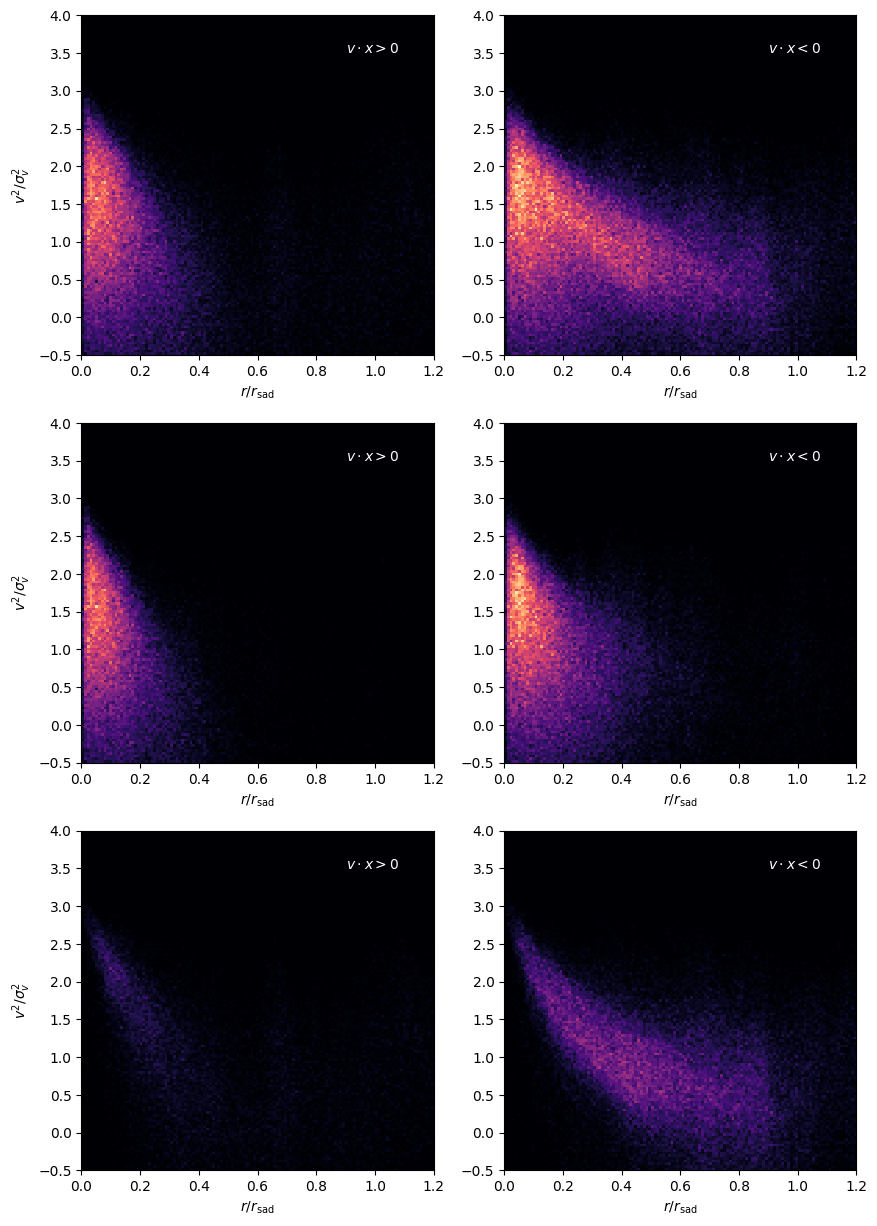

In [9]:
fig, ax = plt.subplots(3,2, figsize = (10,15))
norm = np.max([H_vr_p.max(), H_vr_n.max()])
for k in range(2):
    cmap = "magma"#"RdPu" #"magma"
    v_cents = 0.5*(bins_v[1:] +  bins_v[:-1])
    r_cents = 0.5*(bins_r[1:] +  bins_r[:-1])
    ax[k,0].pcolormesh(r_cents, v_cents, H_vr_p[...,k].T, vmin = 0, vmax = norm, cmap = cmap)
    ax[k,0].set_xlabel(r"$r/r_{\rm sad}$")
    ax[k,0].set_ylabel(r"$v^2/\sigma_v^2$")
    ax[k,0].annotate(r"$v\cdot x > 0$", xy = (0.9,3.5), color = 'w')

    ax[k,1].pcolormesh(r_cents, v_cents, H_vr_n[...,k].T, vmin = 0, vmax = norm, cmap = cmap)
    ax[k,1].set_xlabel(r"$r/r_{\rm sad}$")
    #ax[k,1].set_ylabel(r"$v^2/v^2_{200 \rm c}$")
    ax[k,1].annotate(r"$v\cdot x < 0$", xy = (0.9,3.5), color = 'w')

ax[2,0].pcolormesh(r_cents, v_cents, H_vr_p[...,0].T - H_vr_p[...,1].T, vmin = 0, vmax = norm, cmap = cmap)
ax[2,0].set_xlabel(r"$r/r_{\rm sad}$")
ax[2,0].set_ylabel(r"$v^2/\sigma_v^2$")
ax[2,0].annotate(r"$v\cdot x > 0$", xy = (0.9,3.5), color = 'w')

ax[2,1].pcolormesh(r_cents, v_cents, H_vr_n[...,0].T- H_vr_n[...,1].T, vmin = 0, vmax = norm, cmap = cmap)
ax[2,1].set_xlabel(r"$r/r_{\rm sad}$")
#ax[2,1].set_ylabel(r"$v^2/v^2_{200 \rm c}$")
ax[2,1].annotate(r"$v\cdot x < 0$", xy = (0.9,3.5), color = 'w')
#if save_plots:
#fig.savefig(f"/dipc/trichardson/codes/boosted_hmf/figures/energies_{model}_snap_{t:03}_L{Lbox:.1f}_{len(indices)}M14.pdf")

Putting everything into one plot.

Here again we show outflowing material on the left and inflowing material on the right. We show the previously computed distribution of bound particles in pink and unbound particles in green. The countour levels are chosen to contain, 50%, 84%, and 95%, respectively from darkest to brightest of the total distribution.

Text(0.9, 3.5, '$v\\cdot x < 0$')

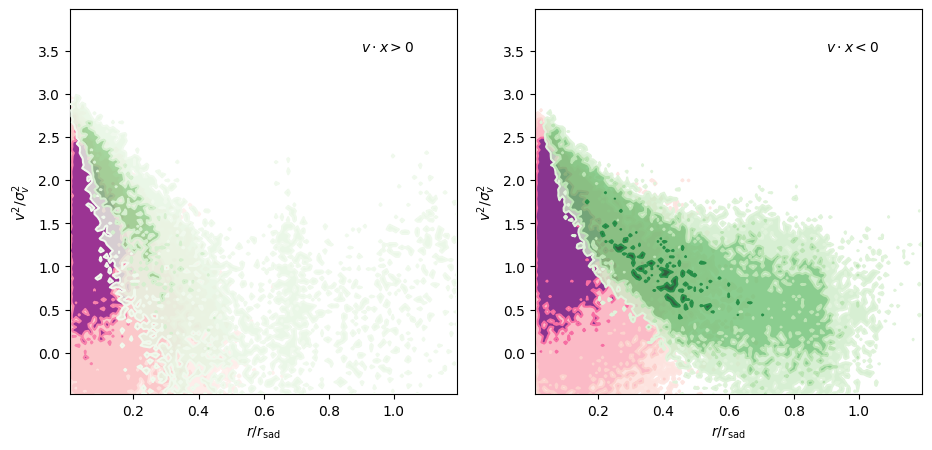

In [21]:
k = 1
fig, ax = plt.subplots(1,2, figsize = (11,5))

v_cents = 0.5*(bins_v[1:] +  bins_v[:-1])
r_cents = 0.5*(bins_r[1:] +  bins_r[:-1])

levels_p = []
for targ in [1-0.95, 1-0.84, 1-0.5]:
    i = 1
    sorted_H = np.sort(H_vr_p[...,0].T.flatten())
    norm = np.sum(H_vr_p[...,0])
    while np.sum(sorted_H[:-i]/norm) > targ:
        i += 1
    levels_p.append(sorted_H[-i])
levels_p.append(sorted_H[-1])
levels_p = np.array(levels_p)

levels_n = []
for targ in [1-0.95, 1-0.84, 1-0.5]:
    i = 1
    sorted_H = np.sort(H_vr_n[...,0].T.flatten())
    norm = np.sum(H_vr_n[...,0])
    while np.sum(sorted_H[:-i]/norm) > targ:
        i += 1
    levels_n.append(sorted_H[-i])
levels_n.append(sorted_H[-1])
levels_n = np.array(levels_n)

vmax = np.max([np.percentile(H_vr_n[np.isfinite(H_vr_n)], 95),np.percentile(H_vr_p[np.isfinite(H_vr_p)], 95)])
vmin = np.min([np.percentile(H_vr_n[np.isfinite(H_vr_n)], 15),np.percentile(H_vr_p[np.isfinite(H_vr_p)], 15)])

fac = 1.5

ax[0].contourf(r_cents, v_cents, H_vr_p[...,1].T, cmap = "RdPu", levels = levels_p, alpha = 0.8, vmax = vmax*fac, vmin = vmin)
ax[0].contour(r_cents, v_cents, H_vr_p[...,1].T, cmap = "RdPu", levels = levels_p, alpha = 1, vmax = vmax*fac, vmin = vmin)

ax[0].contourf(r_cents, v_cents, H_vr_p[...,0].T - H_vr_p[...,1].T, cmap = "Greens", levels = levels_p, alpha = 0.8, zorder = 10, vmax = vmax, vmin = vmin)
ax[0].contour(r_cents, v_cents, H_vr_p[...,0].T - H_vr_p[...,1].T, cmap = "Greens", levels = levels_p, alpha = 1, zorder = 10, vmax = vmax, vmin = vmin)


ax[0].set_xlabel(r"$r/r_{\rm sad}$")
ax[0].set_ylabel(r"$v^2/\sigma_v^2$")
ax[0].annotate(r"$v\cdot x > 0$", xy = (0.9,3.5), color = 'k')


ax[1].contourf(r_cents, v_cents, H_vr_n[...,1].T, cmap = "RdPu", levels = levels_n, alpha = 0.8, vmax = vmax*fac, vmin = vmin)
ax[1].contour(r_cents, v_cents, H_vr_n[...,1].T, cmap = "RdPu", levels = levels_n, alpha = 1, vmax = vmax*fac, vmin = vmin)

ax[1].contourf(r_cents, v_cents, H_vr_n[...,0].T - H_vr_n[...,1].T, cmap = "Greens", levels = levels_n, alpha = 0.8, zorder = 10, vmax = vmax, vmin = vmin)
ax[1].contour(r_cents, v_cents, H_vr_n[...,0].T - H_vr_n[...,1].T, cmap = "Greens", levels = levels_n, alpha = 1, zorder = 10, vmax = vmax, vmin = vmin)

ax[1].set_xlabel(r"$r/r_{\rm sad}$")
ax[1].set_ylabel(r"$v^2/\sigma_v^2$")
ax[1].annotate(r"$v\cdot x < 0$", xy = (0.9,3.5), color = 'k')

In the following we do the same as the provious plot but looking at the radial phase space distribution of particles.

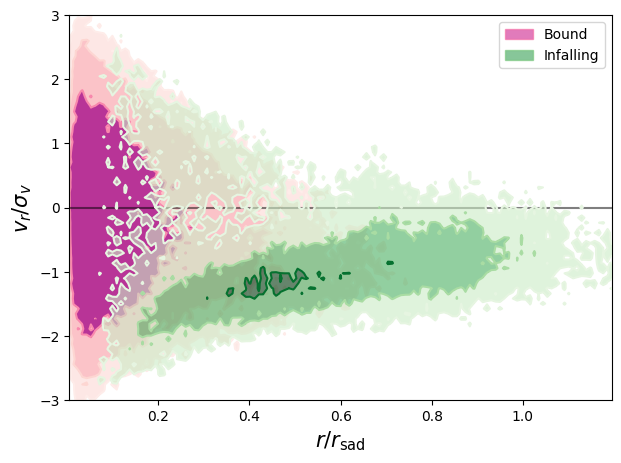

In [23]:
fig, ax = plt.subplots(1,1, figsize = (7,5))
plot_data = (H_VR)

levels = []
for targ in [1-0.95, 1-0.84, 1-0.5]:
    i = 1
    sorted_H = np.sort(plot_data[...,0].T.flatten())
    norm = np.sum(plot_data[...,0])
    while np.sum(sorted_H[:-i]/norm) > targ:
        i += 1
    levels.append(sorted_H[-i])
levels.append(sorted_H[-1])
levels = np.array(levels)


vmax = np.percentile(plot_data[np.isfinite(plot_data)], 95)
vmin = np.percentile(plot_data[np.isfinite(plot_data)], 15)

v_cents = 0.5*(bins_v_phase[1:] +  bins_v_phase[:-1])
r_cents = 0.5*(bins_r[1:] +  bins_r[:-1])
ax.contourf(r_cents, v_cents, plot_data[...,1].T, cmap = "RdPu", levels = levels, alpha = 0.8, vmax = vmax*2, vmin = vmin)
ax.contour(r_cents, v_cents, plot_data[...,1].T, cmap = "RdPu", levels = levels, alpha = 1., vmax = vmax*2, vmin = vmin)

ax.contourf(r_cents, v_cents, plot_data[...,0].T - plot_data[...,1].T, cmap = "Greens", levels = levels, alpha = 0.6, zorder = 10, vmax = vmax, vmin = vmin)
ax.contour(r_cents, v_cents, plot_data[...,0].T - plot_data[...,1].T, cmap = "Greens", levels = levels, alpha = 1., zorder = 10, vmax = vmax, vmin = vmin)


ax.set_xlabel(r"$r/r_{\rm sad}$", fontsize = 15)
ax.set_ylabel(r"$v_r/\sigma_v$", fontsize = 15)
ax.set_ylim(-3,3)
ax.axhline(0, color = 'k', alpha = 0.5)
pink = mpl.colormaps["RdPu"](4/6)
pink_e = mpl.colormaps["RdPu"](3/6)

green = mpl.colormaps["Greens"](4/6)
green_e = mpl.colormaps["Greens"](3/6)
legend_elems = [Patch(facecolor=pink, edgecolor=pink_e, alpha = 0.6,label='Bound'),
               Patch(facecolor=green, edgecolor=green_e, alpha = 0.6, label='Infalling')]
ax.legend(handles=legend_elems, loc='upper right')

# Single halo images

Above we have looked at the stacked distributions of paricles inside haloes of a similar mass. Let us now take an individual look at these haloes individually.

First let us define some geometry functions to beable to place the saddle point, perpendicular to the line of sight specifically, along the x-axis of the image.

In [14]:
def rotate_around_vector(u, psi):
    """
    Function computing the transformation matrix corresponding to a rotation by and angle psi around vector u.
    
    Parameters:
    -------------
    u: (Array of floats) 3D vector around which to perform the rotation
    psi: (float) rotation angle

    Outputs:
    ------------
    R: (3x3 Matrix of floats) Rotation matrix
    """
    c = np.cos(psi)
    s = np.sin(psi)
    C = 1 - c
    x, y, z = u 
    R = np.matrix([[x*x*C + c, x*y*C - z*s, x*z*C + y*s],
                   [y*x*C + z*s, y*y*C + c, y*z*C - x*s],
                   [z*x*C - y*s, z*y*C + x*s, z*z*C + c]])
    return R


def rotate_positions_to_frame(pos, tet, phi, psi = 0):
    """
    Rotates postion from a frame with x along the axis defined by theta and phi and rotated about that axis by an angle psi to a frame with x aligned with [1,0,0].
    
    Parameters:
    -------------
    pos: arrays (3,) of postions
    tet: (float) angle
    phi: (float) angle
    psi: (float) angle

    Outputs:
    -------------
    new_pos: array (3,) of rotated positions
    """
    Rz = np.matrix([[np.cos(phi), -np.sin(phi), 0],
                    [np.sin(phi), np.cos(phi), 0],
                    [0, 0, 1]])
    Ry = rotate_around_vector(np.array([-np.sin(phi), np.cos(phi), 0]), tet - np.pi/2)
    Rpsi = rotate_around_vector(np.array([np.sin(tet)*np.cos(phi), np.sin(tet)*np.sin(phi), np.cos(tet)]), psi)
    return linalg.inv(Rpsi @ Ry @ Rz) @ pos

def rotate_positions_from_frame(pos, tet, phi, psi = 0):
    """
    Rotates postions so that the old x axis is along the axis defined by theta and phi and rotated about that axis by an angle psi.
    
    Parameters:
    -------------
    pos: arrays (3,) of postions
    tet: (float) angle
    phi: (float) angle
    psi: (float) angle

    Outputs:
    -------------
    new_pos: array (3,) of rotated positions
    """
    Rz = np.matrix([[np.cos(phi), -np.sin(phi), 0],
                    [np.sin(phi), np.cos(phi), 0],
                    [0, 0, 1]])
    Ry = rotate_around_vector(np.array([-np.sin(phi), np.cos(phi), 0]), tet - np.pi/2)
    Rpsi = rotate_around_vector(np.array([np.sin(tet)*np.cos(phi), np.sin(tet)*np.sin(phi), np.cos(tet)]), psi)
    return (Rpsi @ Ry @ Rz) @ pos

Then we define a function that is going to project these points using the Cloud-In-Cell (CIC) approach.

In [3]:
def CIC(x, y, xbins = 64, ybins = 64, values = None):
    '''
     This function creates a 2D clond-in-cell (CIC) projection of positions x and y. 
     xbins and ybins can be either an integer number of bins or an array of bin edges 
     Positions can also be weighted using the values argument.

     Parameters:
     ------------
     x: (Array of floats) x coordinates of points to be projected
     y: (Array of floats) y coordinates of points to be projected
     xbins: (int or Array of floats) If int then defines the number of bins used between min(x) and max(x). If array of floats uses these values as bin edges.
     ybins: (int or Array of floats) If int then defines the number of bins used between min(y) and max(y). If array of floats uses these values as bin edges.
     values: (Array of floats) weights of points to be projected. Must be the same size as x and y

     Outputs:
     ------------
     H: (2D Array of floats) CIC projected field
     xbins: (Array of floats) Bin edges along x axis
     ybins: (Array of floats) Bin edges along y axis
    '''
    has_vals = True
    if x.size != y.size:
        raise ValueError("x and y must be the same length")
    if values is None:
        has_vals = False
        values = np.ones(x.size)
    elif np.array(values).size == 1:
        values = values * np.ones(x.size)
    elif values.size != x.size:
        raise ValueError("position and value vectors must be the same length")
    if np.array(xbins).size == 1 and type(xbins) == int:
        xbins = np.linspace(x.min(), x.max(), xbins)
    elif np.array(xbins).size == 1 and type(xbins) != int:
        raise ValueError("xbins must be either int or array")
    elif not np.all(np.diff(xbins) - np.mean(np.diff(xbins)) < 1e-8 * np.mean(np.diff(xbins)) ):
        raise ValueError("xbins must be equally spaced")
    if np.array(ybins).size == 1 and type(ybins) == int:
        ybins = np.linspace(y.min(), y.max(), ybins)
    elif np.array(ybins).size == 1 and type(ybins) != int:
        raise ValueError("ybins must be either int or array")
    elif not np.all(np.diff(ybins) - np.mean(np.diff(ybins)) < 1e-8 * np.mean(np.diff(xbins))):
        raise ValueError("ybins must be equally spaced")
    
    
    dx = np.mean(np.diff(xbins))
    dy = np.mean(np.diff(ybins))
    xp = (x - xbins.min())/dx - 0.5; yp = (y - ybins.min())/dy - 0.5
    i = np.floor(xp); j = np.floor(yp)
    tx = xp - i; ty = yp - j
    dx = 1 - tx; dy = 1 - ty
    order = [(0,0),(1,0),(0,1),(1,1)]
    facs = [(tx,ty), (dx, ty), (tx, dy), (dx, dy)]
    H = np.zeros((xbins.size-1, ybins.size-1))
    H_N = np.zeros((xbins.size-1, ybins.size-1))
    for k in range(4):
        h_N, xedges, yedges = np.histogram2d(i + order[k][0],j + order[k][1], bins = (np.arange(xbins.size),np.arange(ybins.size)), weights = facs[k][0]*facs[k][1])
        h, xedges, yedges = np.histogram2d(i + order[k][0],j + order[k][1], bins = (np.arange(xbins.size),np.arange(ybins.size)), weights = facs[k][0]*facs[k][1]*values)
        H += h
        H_N += h_N
    if has_vals:
        H_N[H_N == 0] = 1
        H /= H_N
    return H, xbins, ybins

Finally we create the images

['11.2', '-0.0', '-0.0']


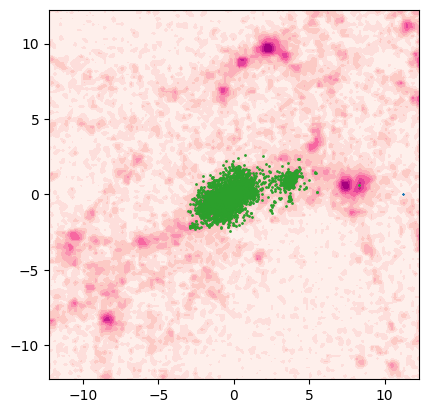

In [29]:
i_halo = 4 # Index of the halo to be imaged in the previous analysis

# Get saddle point vector
x_sad = pa.recentre_positions_numpy(pos[halo_i_sad[i_halo]], halo_x0[i_halo])
# Get spherical coordinates of the saddle point vector
r_sad = np.sqrt(np.sum(x_sad**2))
tet = np.arccos(x_sad[2]/r_sad)
phi = np.sign(x_sad[1]) * np.arccos(x_sad[0]/np.sqrt(x_sad[0]**2 + x_sad[1]**2))

# define width of the image
width = 2.2*r_sad

xx = np.linspace(-width/2, width/2, 128)
yy = np.linspace(-width/2, width/2, 128)
zz = np.linspace(-width/2, width/2, 31) # We also define a z-axis to project the potential using nearest point approximation.
X, Y, Z = np.meshgrid(xx,yy,zz)
xi = np.vstack([X.flatten(),Y.flatten(), Z.flatten()])

# Select all particles around the desired halor
part_ids = tree.query_ball_point(halo_x0[i_halo], r = np.sqrt(3)*width/2)
x = pa.recentre_positions_numpy(pos[part_ids], halo_x0[i_halo])

# Set up a Halo object to compute de boosted potential
halo = Halo(pot.size)
halo.reset_computed_particles()
# Give it the parameters used in the analysis
halo.set_x0(halo_i_min[i_halo], halo_x0[i_halo])
halo.set_acc0(halo_acc0[i_halo])

# Rotate all coordinates to the frame where the saddle point vector is aligned with the x-axis
x_plt = rotate_positions_to_frame(x.T, tet, phi).T # Everything
x_in = rotate_positions_to_frame(x_save[1][i_halo].T, tet, phi).T # Bound particles
x_sad_rot = rotate_positions_to_frame(x_sad, tet, phi).T # Rotated saddlepoint vector (Computed for consitency, should always be [r_sad, 0 ,0])
print([f"{coord:.1f}" for coord in x_sad_rot])

# Compute density field
H_dens, xbins, ybins = CIC(x_plt[:,0], x_plt[:,1], xx, yy)
# Potential field
H_pot = griddata(points = x_plt, values = pot[part_ids], xi = xi.T, method = 'nearest').reshape(X.shape)
# Boosted potential field (setting the saddle point level to be 0)
H_boost = griddata(points = x_plt, values = pa.get_phi_boost(part_ids, halo) - pa.get_phi_boost(halo_i_sad[i_halo], halo), xi = xi.T, method = 'nearest').reshape(X.shape)

# Plot density field and bound particles
plt.contourf(0.5*(xx[1:] + xx[:-1]), 0.5*(yy[1:] + yy[:-1]),np.log10(H_dens.T+1), vmin = 0., levels = 10, cmap = "RdPu")
plt.scatter(x_in[:,0], x_in[:,1], marker = 'o', s = 1, c= 'tab:green', alpha = 1)
plt.scatter(x_sad_rot[0], x_sad_rot[1], marker = 'x', s = 1, c= 'tab:blue')
plt.axis("image");

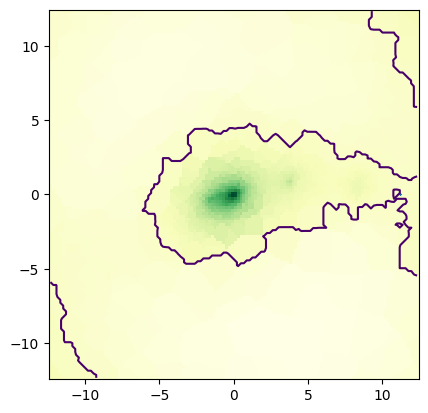

In [30]:
# Plot slice of the boosted potential passing trhough the minimum and saddle point
plt.pcolormesh(xx,yy,H_boost[...,15], cmap = "YlGn_r")
plt.contour(xx,yy,H_boost[...,15], levels = [-1e32, 0], cmap = "RdPu")
plt.scatter(x_sad_rot[0], x_sad_rot[1], marker = 'x', s = 1, c= 'tab:blue')
plt.axis("image");

# /!\ RUN CELL BELLOW BEFORE EXITING TO ENSURE SHARED MEMORY IS FREED

In [31]:
for shm in shm_objects:
    try:
        shm.close()
        shm.unlink()
    except FileNotFoundError:
        pass